In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import json
import gc
from typing import Tuple, Optional, Dict
from functools import partial

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage
import wandb

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from research.data.natural_scenes import (
    NaturalScenesDataset,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
nsd_path = Path('D:\\Datasets\\NSD')
nsd = NaturalScenesDataset(nsd_path)

In [53]:
subject_name = 'subj04'
voxel_selection_path = 'derivatives/noise-ceiling.hdf5'
voxel_selection_key = 'split-01/value'

voxel_selection_file = h5py.File(nsd.dataset_path / voxel_selection_path, 'r')
key = f'{subject_name}/{voxel_selection_key}'
nc = voxel_selection_file[key][:].T

In [ ]:
p = nsd.dataset_path / voxel_selection_path
p.parent / f'lh.{p.name}'

In [6]:
# Generate random colormap
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [54]:
from skimage.morphology import dilation

labelmap_names = list(nsd.subjects[subject_name]['roi_paths'].keys())
print(labelmap_names)

roi_name = 'HCP_MMP1'
label_image, label_names = nsd.load_roi(subject_name, roi_name)
cmap = rand_cmap(nlabels=max(label_names.keys()), verbose=False)

H, W, D = label_image.shape
thres=5
@interact(d=(0, D-1), dilation_iters=(0, 6), show_nc=False,)
def show(d, dilation_iters, show_nc=False, ):
    x = label_image.copy()
    
    for i in range(dilation_iters):
        background = x < 1
        x[background] = dilation(x)[background]
    
    nc_thres = nc > thres
    nc_show = np.zeros_like(nc_thres, dtype=int)
    good = nc_thres & (x >= 1)
    bad = nc_thres & (x < 1)
    nc_show[bad] = 1
    nc_show[good] = -1
    print(good.sum(), bad.sum())
    plt.figure(figsize=(12, 12))
    
    if show_nc:
        plt.imshow(nc_show[:, :, d], vmin=-1, vmax=1, cmap='bwr')
    else:
        plt.imshow(x[:, :, d], cmap=cmap)

['brainmask', 'aseg', 'hippoSfLabels', 'corticalsulc', 'floc-bodies', 'floc-faces', 'floc-places', 'floc-words', 'HCP_MMP1', 'Kastner2015', 'MTL', 'nsdgeneral', 'prf-eccrois', 'streams', 'thalamus', 'wm', 'aparc', 'aparc.DKTatlas', 'aparc.a2009s', 'HCP_MMP1_cortices', 'lh.brainmask', 'lh.aseg', 'lh.hippoSfLabels', 'lh.corticalsulc', 'lh.floc-bodies', 'lh.floc-faces', 'lh.floc-places', 'lh.floc-words', 'lh.HCP_MMP1', 'lh.Kastner2015', 'lh.MTL', 'lh.nsdgeneral', 'lh.prf-eccrois', 'lh.streams', 'lh.thalamus', 'lh.wm', 'lh.aparc', 'lh.aparc.DKTatlas', 'lh.aparc.a2009s', 'lh.HCP_MMP1_cortices', 'rh.brainmask', 'rh.aseg', 'rh.hippoSfLabels', 'rh.corticalsulc', 'rh.floc-bodies', 'rh.floc-faces', 'rh.floc-places', 'rh.floc-words', 'rh.HCP_MMP1', 'rh.Kastner2015', 'rh.MTL', 'rh.nsdgeneral', 'rh.prf-eccrois', 'rh.streams', 'rh.thalamus', 'rh.wm', 'rh.aparc', 'rh.aparc.DKTatlas', 'rh.aparc.a2009s', 'rh.HCP_MMP1_cortices', 'rh.lh.brainmask', 'rh.lh.aseg', 'rh.lh.hippoSfLabels', 'rh.lh.corticalsulc

interactive(children=(IntSlider(value=39, description='d', max=79), IntSlider(value=3, description='dilation_i…

In [84]:
label_counts = {}
for i in range(8):
    subject_name = f'subj0{i+1}'
    #voxel_selection_path = 'derivatives/voxel-selection.hdf5'
    #voxel_selection_key = 'nc/value'
    
    voxel_selection_path = 'derivatives/encoded_betas/clip-vit-large-patch14-text/fracridge.hdf5'
    voxel_selection_key = 'embedding_unpooled'

    voxel_selection_file = h5py.File(nsd.dataset_path / voxel_selection_path, 'r')
    key = f'{subject_name}/{voxel_selection_key}'
    nc = nsd.reconstruct_volume(
        subject_name, 
        torch.from_numpy(voxel_selection_file[f'{key}/r2'][:]), 
        voxel_selection_file[f'{key}/volume_indices'][:]
    ).numpy().T * 100
    #nc = voxel_selection_file[key][:].T

    roi_name = 'HCP_MMP1_cortices'
    label_counts[subject_name] = {}
    #for hemi in ('lh', 'rh'):
    label_image, label_names = nsd.load_roi(subject_name, f'{roi_name}')

    background = label_image < 1
    label_image[background] = dilation(label_image)[background]

    threshold = 5.
    selection_map = nc > threshold
    label_counts[subject_name].update({
        (label_id, f'{label_name}'): ((label_image == label_id) & selection_map).sum()
        for label_id, label_name in label_names.items()
    })
    

In [57]:
label_names

{0: 'Unknown',
 1: 'Primary_Visual',
 2: 'Early_Visual',
 3: 'Dorsal_Stream_Visual',
 4: 'Ventral_Stream_Visual',
 5: 'MT+_Complex_and_Neighboring_Visual_Areas',
 6: 'Somatosensory_and_Motor',
 7: 'Paracentral_Lobular_and_Mid_Cingulate',
 8: 'Premotor',
 9: 'Posterior_Opercular',
 10: 'Early_Auditory',
 11: 'Auditory_Association',
 12: 'Insular_and_Frontal_Opercular',
 13: 'Medial_Temporal',
 14: 'Lateral_Temporal',
 15: 'Temporo-Parieto-Occipital_Junction',
 16: 'Superior_Parietal',
 17: 'Inferior_Parietal',
 18: 'Posterior_Cingulate',
 19: 'Anterior_Cingulate_and_Medial_Prefrontal',
 20: 'Orbital_and_Polar_Frontal',
 21: 'Inferior_Frontal',
 22: 'Dorsolateral_Prefrontal',
 -1: 'Unlabeled'}

In [117]:
labels = list(label_counts['subj01'].keys())

with h5py.File(nsd_path / 'derivatives/roi-selection.h5py', 'w') as f:
    for i in range(8):
        subject_name = f'subj0{i+1}'
        print(subject_name)

        model_name = 'clip-vit-large-patch14-text'
        encoder_name = 'fracridge'
        voxel_selection_path = f'derivatives/encoded_betas/{model_name}/{encoder_name}.hdf5'
        voxel_selection_key = 'embedding_unpooled'

        voxel_selection_file = h5py.File(nsd.dataset_path / voxel_selection_path, 'r')
        key = f'{subject_name}/{voxel_selection_key}'
        value = nsd.reconstruct_volume(
            subject_name, 
            torch.from_numpy(voxel_selection_file[f'{key}/r2'][:]), 
            voxel_selection_file[f'{key}/volume_indices'][:]
        ).numpy()

        roi_name = 'HCP_MMP1_cortices'
        label_counts[subject_name] = {}
        #for hemi in ('lh', 'rh'):
        label_image, label_names = nsd.load_roi(subject_name, f'{roi_name}')
        label_image = label_image.T

        background = label_image < 1
        label_image[background] = dilation(label_image)[background]
        
        save_labels = list(label_names.items())
        save_labels.append(([19, 20, 21, 22], "Frontal"))
        
        for label_id, label_name in save_labels:
            if label_id in (0, -1):
                continue
            if isinstance(label_id, int):
                label_id = [label_id]
            
            label_mask = np.zeros_like(label_image, dtype=bool)
            for i in label_id:
                label_mask = label_mask | (label_image == i)
            
            r2_values = value[label_mask]
            volume_ids = np.stack(np.where(label_mask), axis=-1)
            flat_ids = np.argwhere(label_mask.flatten())[:, 0]
            
            argsort_ids = np.argsort(r2_values)[::-1]
            
            group = f.require_group(f'{subject_name}/{model_name}/{encoder_name}/{voxel_selection_key}/{label_name}')
            group['sorted_indices'] = volume_ids[argsort_ids]
            group['sorted_indices_flat'] = flat_ids[argsort_ids]
            group['value'] = r2_values[argsort_ids]


subj01
subj02
subj03
subj04
subj05
subj06
subj07
subj08


In [85]:
labels = list(label_counts['subj01'].keys())
label_count_summary = {}
counts = np.stack([
    np.array([
        label_counts[subject][label]
        for subject in label_counts
    ])
    for label in labels
])
print(counts.shape)

(24, 8)


In [ ]:
rois = [
    'Primary_Visual', 'Early_Visual', 'Dorsal_Stream_Visual', 'Ventral_Stream_Visual', 
    'MT+_Complex_and_Neighboring_Visual_Areas', 'Medial_Temporal', 'Lateral_Temporal',
    'Temporo-Parieto-Occipital_Junction', 'Superior_Parietal', 'Inferior_Parietal',
    'Posterior_Cingulate', 'Frontal',
]


In [86]:
list(zip(labels, counts))

[((0, 'Unknown'), array([ 61, 211,  39,  47, 132,  70,  37,   0])),
 ((1, 'Primary_Visual'), array([170, 417, 192, 169, 517, 227,  99, 114])),
 ((2, 'Early_Visual'),
  array([ 648,  711,  292,  342, 1239,  810,  240,  272])),
 ((3, 'Dorsal_Stream_Visual'),
  array([396, 237, 143, 130, 564, 303, 113,  36])),
 ((4, 'Ventral_Stream_Visual'),
  array([ 922,  983,  735,  706, 1243, 1110,  294,  446])),
 ((5, 'MT+_Complex_and_Neighboring_Visual_Areas'),
  array([1414, 1397, 1123, 1224, 1614, 1707,  975,  465])),
 ((6, 'Somatosensory_and_Motor'), array([ 2, 13,  1, 16, 34, 11,  7,  0])),
 ((7, 'Paracentral_Lobular_and_Mid_Cingulate'),
  array([46,  5,  7, 19, 37, 29,  7,  0])),
 ((8, 'Premotor'), array([ 53,  80,  29, 111, 142,  21, 109,   4])),
 ((9, 'Posterior_Opercular'), array([1, 2, 0, 1, 1, 0, 0, 0])),
 ((10, 'Early_Auditory'), array([60, 14,  0,  0,  2,  5,  1,  0])),
 ((11, 'Auditory_Association'), array([14, 54,  0, 49, 38,  1, 30,  0])),
 ((12, 'Insular_and_Frontal_Opercular'),
  ar

In [118]:
[
    (label[1], int(np.max(count))) 
    for label, count in zip(labels, counts)
]
    


[]

In [115]:
np.max(counts[19:23].sum(axis=0))

492

In [91]:
np.median(counts, axis=1).astype(int)

array([  54,  181,  495,  190,  828, 1310,    9,   13,   66,    0,    1,
         22,    9,  228,  201,  661,  174,  486,  359,    3,    6,   48,
         27,    0])

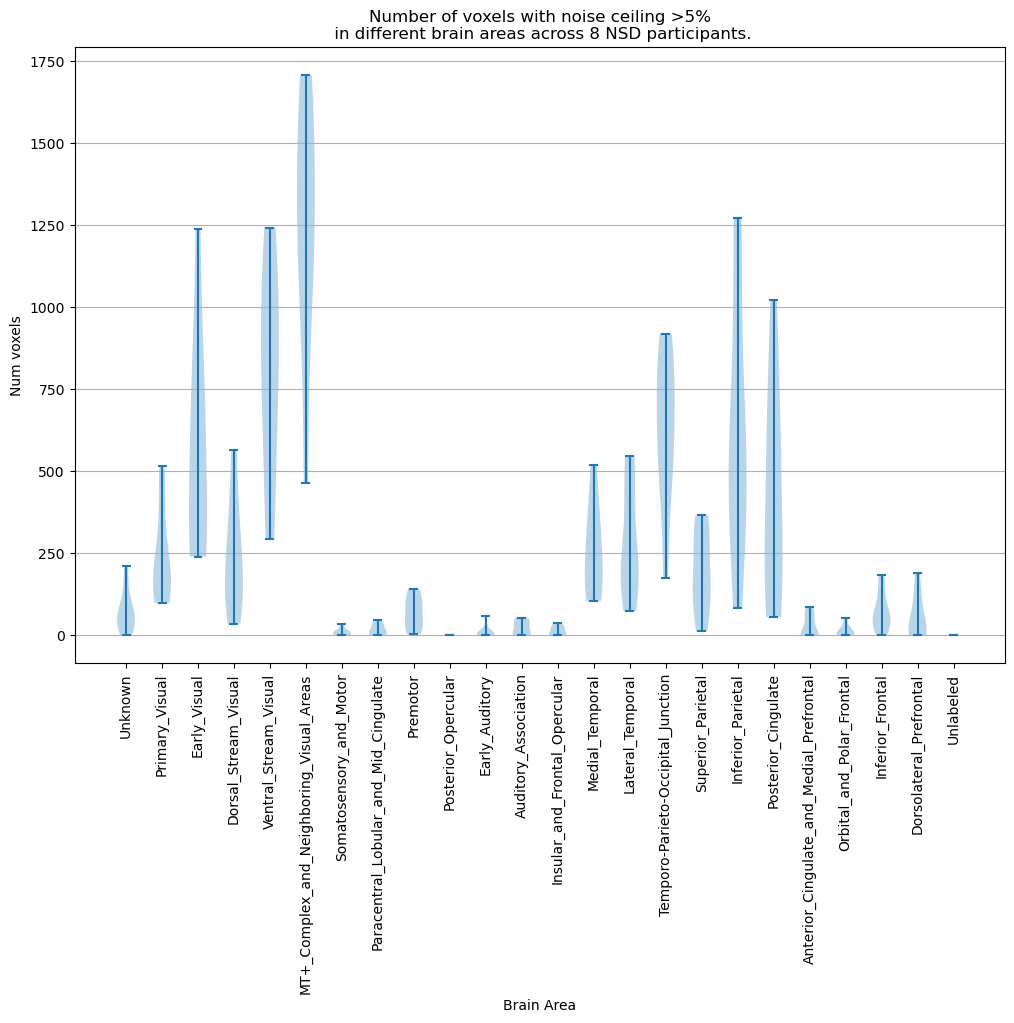

In [93]:
#minimum_count = -1

#count_mask = np.median(counts, axis=1) > minimum_count

fig, ax = plt.subplots(figsize=(12, 8))
num_labels, num_subjects = counts.shape
ax.violinplot(list(counts[count_mask]))
ax.set_xticks(
    np.arange(count_mask.sum()) + 1,
    labels=[elem[1] for elem in np.array(labels)[count_mask]],
    rotation=90,
)
ax.yaxis.grid(True)
ax.set_xlabel('Brain Area')
ax.set_ylabel(f'Num voxels')
ax.set_title(f'Number of voxels with noise ceiling >{int(threshold)}%\n in different brain areas across 8 NSD participants.')

plt.show()

In [ ]:
x = list(label_counts['subj01'].items())
x.sort(key=lambda elem: elem[1], reverse=True)
x

In [ ]:
0.2**2 / (0.2**2 + 1)